# Multi Layer Neural network

## Introduction

In the previous experiments, we explored simple **bigram models** and **single-layer perceptrons**.
While these models were useful for understanding the basics, they failed to capture **longer contexts** in names and often produced unrealistic generations.

In this notebook, we extend the approach to a **Multi-Layer Perceptron (MLP)** that uses embeddings and hidden layers to learn richer representations of context.

Key steps include:
- Converting raw text (names) into input-output training pairs using a **context window (block size)**.
- Encoding characters into a **low-dimensional embedding space**.
- Passing embeddings through a **hidden layer** with non-linear activation (`tanh`).
- Using an **output layer** to predict probabilities for the next character.
- Training the model with **cross-entropy loss** and **gradient descent**, updating parameters iteratively.
- Experimenting with **mini-batch training** and **learning rate scheduling** to improve efficiency.

This workflow builds the foundation for **modern neural language models**, bridging from simple count-based models to deep learning methods.

---


### Problem with the Bigram Model
- The bigram model captures only **2 characters** of context.
- This gives us:

$$
27 \times 27 = 729 \text{ combinations}
$$

If we extend to **3 characters of context**, the possibilities grow rapidly:

$$
27 \times 27 \times 27 = 19{,}683 \text{ combinations}
$$

As context length increases, creating count vectors, normalizing, and training become increasingly difficult.

---

### Our Approach
We follow the modeling approach from **Bengio et al., 2003**:
[A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {
    s: i+1 for i,s in enumerate(chars)
}
stoi['.'] = 0
itos = { i:s for s,i in stoi.items() }


## Creating dataset for Neural Networks from Text File to Input Tensor and Output Tensor

In [6]:
## data set for neural network

block_size = 3 #Context_length: how many characters do we take to predict the next one?
X,Y =[],[] # X are the input to neural network and Y are  the labels of the neural network

for w in words[:1]:

    print(w)
    context = [0] * block_size

    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        print("input data : ",''.join(itos[i] for i in context), ", Output :", '=', itos[ix])
        print('context :', context)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


print('\n')
print("input tensor :", X)

print("output tensor :", Y)

emma
input data :  ... , Output : = e
context : [0, 0, 0]
input data :  ..e , Output : = m
context : [0, 0, 5]
input data :  .em , Output : = m
context : [0, 5, 13]
input data :  emm , Output : = a
context : [5, 13, 13]
input data :  mma , Output : = .
context : [13, 13, 1]


input tensor : tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])
output tensor : tensor([ 5, 13, 13,  1,  0])


### Example: Using the word *emma*

To illustrate how the input-output pairs are formed, we take the word **"emma"** with context size = 3.
At each step, the model looks at the **previous 3 characters** (context) and predicts the **next character**.

---

### Input-Output Mapping

| Input Data | Output | stoi encoding |
|------------|--------|---------------|
| `...`      | `e`    | [0, 0, 0]     |
| `..e`      | `m`    | [0, 0, 5]     |
| `.em`      | `m`    | [0, 5, 13]    |
| `emm`      | `a`    | [5, 13, 13]   |
| `mma`      | `.`    | [13, 13, 1]   |

---

### Key Takeaway
- The model uses **3-character context** to predict the next character.
- Special tokens like `"."` are used to mark the **start** and **end** of words.
- This process transforms raw text into **training pairs** (input → output) that the neural network learns from.


# Block size = 5

In [7]:
block_size = 5 #Context_length: how many characters do we take to predict the next one?
X,Y =[],[] # x are inputs and Y are labels

for w in words[:1]:

    print( 'word is :',w)

    print('\n')
    print('input -->  output')
    context = [0] * block_size

    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        print(''.join(itos[i] for i in context), "--> ", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


print('\n')
print("input tensor :", X)

print("output tensor :", Y)

word is : emma


input -->  output
..... -->  e
....e -->  m
...em -->  m
..emm -->  a
.emma -->  .


input tensor : tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  5],
        [ 0,  0,  0,  5, 13],
        [ 0,  0,  5, 13, 13],
        [ 0,  5, 13, 13,  1]])
output tensor : tensor([ 5, 13, 13,  1,  0])


In [8]:
X

tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  5],
        [ 0,  0,  0,  5, 13],
        [ 0,  0,  5, 13, 13],
        [ 0,  5, 13, 13,  1]])

In [9]:
import pandas as pd
pd.DataFrame(Y)

,0
0,5
1,13
2,13
3,1
4,0


### above we are trying to take 5 character as input and predicting what comes next as o/p

In [10]:
block_size = 3 #Context_length: how many characters do we take to predict the next one?
X,Y =[],[] # x are inputs and Y are labels

for w in words[:5]:

    #print(w)
    context = [0] * block_size

    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        #print("input data : ",''.join(itos[i] for i in context), ", Output :", '=', itos[ix])
        #print('context :', context)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [11]:
import pandas as pd
pd.DataFrame(Y)

,0
0,5
1,13
2,13
3,1
4,0
5,15
6,12
7,9
8,22
9,9


### Training Data is Ready

1. The training data with **block_size/context = 3** is now prepared.
2. The corresponding outputs are also ready for the model to train on.


In [12]:
(X.shape, X.dtype), (Y.shape, Y.dtype)

((torch.Size([32, 3]), torch.int64), (torch.Size([32]), torch.int64))

## Tensor Setup

- Our tensor matrix **X** has `228,146` rows and `3` columns, with both columns having `dtype = integer`.

- In the reference paper, they used **17,000 words**, each embedded in a **30-dimensional space**.

- In our case, we have only **27 possible characters**, so we will use a **2-dimensional space**.
  - This means we will have a tensor of shape **27 × 2** to represent all characters.


In [13]:
# let embedded the 2 random numbers with 27*2

C = torch.randn((27,2)) # this is used as an embedding layer
C

tensor([[-0.7449, -0.4585],
        [-1.7828,  0.3992],
        [ 1.8466,  0.9018],
        [ 0.6683,  0.0556],
        [ 1.8014,  0.9805],
        [ 0.6096, -0.6466],
        [ 0.5734,  0.1692],
        [ 0.9185, -1.8598],
        [-0.1182,  0.5036],
        [-2.0337, -0.2660],
        [-0.6742,  0.6095],
        [ 0.9076, -0.1282],
        [-0.1066,  2.7571],
        [-0.1990,  1.0903],
        [-1.4460, -1.3872],
        [ 0.3560,  0.1844],
        [ 1.7420, -2.9093],
        [ 0.4414,  0.7655],
        [ 0.0964,  0.0126],
        [-0.1465, -1.2818],
        [-0.7004,  0.0200],
        [ 1.1540,  0.5290],
        [-0.7146, -0.7522],
        [-1.5216,  0.0821],
        [-1.1048, -1.3288],
        [ 2.2363,  1.0640],
        [-0.4536,  0.6131]])

In [14]:
# Embedding of number 5 in C encoding
C[5]

tensor([ 0.6096, -0.6466])

### Example of Encoding

Suppose we want to encode the number **5** when the total number of classes = **27 (characters)**.
We use one-hot encoding and then multiply it with the weight matrix.

$$
[1 \times 27] \; @ \; [27 \times 2] \; = \; [1 \times 2] \; \text{tensor}
$$

- **[1 × 27]** → One-hot encoded vector for class index = 5
- **[27 × 2]** → Weight matrix (each character embedded in 2D space)
- **[1 × 2]** → Encoded vector in the 2D embedding space


In [15]:
#Example of encoding the number 5 with number of classes = 27(charac) and multiplying it with the weights matrix
# [1*27] @ [27*2] = [1*2] tensor

(F.one_hot(torch.tensor(5), num_classes=27).float()) @ C

tensor([ 0.6096, -0.6466])

### First Layer Computation

If we look up the embedding matrix **C** at the given input index **X**,
we directly obtain the **result from the first layer**:

$$
\text{Output} = C[X]
$$

- **C** → Embedding matrix
- **X** → Input index (or context indices)
- **C[X]** → Corresponding embedding vector(s)


In [16]:
C = torch.randn((27,2))
C ## c is noting buit one type of encoding

tensor([[ 0.2942,  0.2740],
        [ 0.2644, -1.6462],
        [-0.7768, -0.1596],
        [-0.9592, -1.1740],
        [-0.9742,  0.3060],
        [ 0.3096,  0.0227],
        [-0.0236, -0.5425],
        [-0.5322, -0.3443],
        [-2.1710,  0.4784],
        [ 0.6612, -0.0670],
        [-1.0901, -0.3320],
        [ 1.0183, -2.0291],
        [-0.7829, -1.5884],
        [-1.1424,  0.3848],
        [-0.9952,  0.4301],
        [-0.3984, -0.9173],
        [ 0.4635, -0.0327],
        [-0.7100,  0.9021],
        [-0.8982, -0.8947],
        [-0.0979,  0.9512],
        [ 0.3273, -0.8611],
        [-1.9008,  1.1420],
        [-2.1613, -0.3094],
        [-1.4496,  0.9121],
        [ 1.7011,  0.2139],
        [-1.2487,  0.3933],
        [ 0.0188,  2.1263]])

In [17]:
# we want to encode one number 5 we can simply pass this number to the Embedding tensor C and get the output i.e.,

C[5] #Give embedding of 5 in 2d Vector Space

tensor([0.3096, 0.0227])

In [18]:
# what if the embedding is like list
print(C[[2,3,4]]) # we got the embedding of 3 integer vector as below


tensor([[-0.7768, -0.1596],
        [-0.9592, -1.1740],
        [-0.9742,  0.3060]])


In [19]:
# what if we give the tensor input to get embedding

print(C[torch.tensor([5,6,7,7,7,7,7,7,])]) # still we are able to get the embedding by giving tensor matrix as input

tensor([[ 0.3096,  0.0227],
        [-0.0236, -0.5425],
        [-0.5322, -0.3443],
        [-0.5322, -0.3443],
        [-0.5322, -0.3443],
        [-0.5322, -0.3443],
        [-0.5322, -0.3443],
        [-0.5322, -0.3443]])


### Explanation of **C** (Embedding Matrix)

- **C** is the embedding matrix.
- When you pass a **single integer**, you get the embedding vector for that specific index.
- When you pass a **list of integers**, you get the embeddings for each element in the list.
- When you pass a **tensor of indices**, you get the embeddings for the entire tensor.

---

### Formula

If **C** has shape:

$$
[\text{vocab\_size} \times \text{embedding\_dim}]
$$

and **X** is an index or collection of indices, then:

$$
\text{Output} = C[X]
$$

---

### Example

- **Single index:**
  $$ C[5] \;\;\to\;\; [1 \times \text{embedding\_dim}] $$

- **List of indices:**
  $$ C[[5, 13, 1]] \;\;\to\;\; [3 \times \text{embedding\_dim}] $$

- **Tensor of shape (batch, context):**
  $$ C[X] \;\;\to\;\; [\text{batch} \times \text{context} \times \text{embedding\_dim}] $$


In [20]:
embedding = C[X]
embedding

tensor([[[ 0.2942,  0.2740],
         [ 0.2942,  0.2740],
         [ 0.2942,  0.2740]],

        [[ 0.2942,  0.2740],
         [ 0.2942,  0.2740],
         [ 0.3096,  0.0227]],

        [[ 0.2942,  0.2740],
         [ 0.3096,  0.0227],
         [-1.1424,  0.3848]],

        [[ 0.3096,  0.0227],
         [-1.1424,  0.3848],
         [-1.1424,  0.3848]],

        [[-1.1424,  0.3848],
         [-1.1424,  0.3848],
         [ 0.2644, -1.6462]],

        [[ 0.2942,  0.2740],
         [ 0.2942,  0.2740],
         [ 0.2942,  0.2740]],

        [[ 0.2942,  0.2740],
         [ 0.2942,  0.2740],
         [-0.3984, -0.9173]],

        [[ 0.2942,  0.2740],
         [-0.3984, -0.9173],
         [-0.7829, -1.5884]],

        [[-0.3984, -0.9173],
         [-0.7829, -1.5884],
         [ 0.6612, -0.0670]],

        [[-0.7829, -1.5884],
         [ 0.6612, -0.0670],
         [-2.1613, -0.3094]],

        [[ 0.6612, -0.0670],
         [-2.1613, -0.3094],
         [ 0.6612, -0.0670]],

        [[-2.1613, -0

In [21]:
embedding.shape

torch.Size([32, 3, 2])

now our input is embeeded

In [22]:
# so to convert the input vector to 2 dimensional space there are manu ways to represent it
# but one of the effective and easiest way pass dotview  .view(x,6)

embedding.view(-1, 6)

tensor([[ 0.2942,  0.2740,  0.2942,  0.2740,  0.2942,  0.2740],
        [ 0.2942,  0.2740,  0.2942,  0.2740,  0.3096,  0.0227],
        [ 0.2942,  0.2740,  0.3096,  0.0227, -1.1424,  0.3848],
        [ 0.3096,  0.0227, -1.1424,  0.3848, -1.1424,  0.3848],
        [-1.1424,  0.3848, -1.1424,  0.3848,  0.2644, -1.6462],
        [ 0.2942,  0.2740,  0.2942,  0.2740,  0.2942,  0.2740],
        [ 0.2942,  0.2740,  0.2942,  0.2740, -0.3984, -0.9173],
        [ 0.2942,  0.2740, -0.3984, -0.9173, -0.7829, -1.5884],
        [-0.3984, -0.9173, -0.7829, -1.5884,  0.6612, -0.0670],
        [-0.7829, -1.5884,  0.6612, -0.0670, -2.1613, -0.3094],
        [ 0.6612, -0.0670, -2.1613, -0.3094,  0.6612, -0.0670],
        [-2.1613, -0.3094,  0.6612, -0.0670,  0.2644, -1.6462],
        [ 0.2942,  0.2740,  0.2942,  0.2740,  0.2942,  0.2740],
        [ 0.2942,  0.2740,  0.2942,  0.2740,  0.2644, -1.6462],
        [ 0.2942,  0.2740,  0.2644, -1.6462, -2.1613, -0.3094],
        [ 0.2644, -1.6462, -2.1613, -0.3

## Hidden Layer

## Passing to the Second Layer from embedding layer

- The **second layer** consists of a weight matrix \( W_1 \) and a bias vector \( b_1 \).
- The output of the second layer is computed as:

$$
h = X \cdot W_1 + b_1
$$

- If we apply the non-linearity (**tanh**), we get:

$$
h = \tanh(W_1 \cdot X + b_1)
$$

---

### Example
- Suppose the second layer has **100 weights** → \( W_1 \) has shape:

$$
[\text{input\_dim} \times 100]
$$

- Then there are **100 biases** → \( b_1 \) has shape:

$$
[1 \times 100]
$$

- The final hidden representation is:

$$
h \in \mathbb{R}^{1 \times 100}
$$


In [23]:
## now if we want to pass it to the second layer

# consider second layer as weight w1 and bias b1
# then o/p of second layer = i/p @w1 + b1

#lets consider we have 100 weights in second layer such that we have 100 biases in second layer too h = tanh(w1*x1 + b1)

W1 = torch.rand((6,100))
B1 = torch.rand(100)

In [24]:
h = torch.tanh(embedding.view(-1, 6) @ W1 + B1)
h

tensor([[ 0.8210,  0.7669,  0.7081,  ...,  0.6870,  0.8840,  0.8089],
        [ 0.7252,  0.6706,  0.5843,  ...,  0.5487,  0.8595,  0.8079],
        [ 0.6842,  0.0850,  0.3786,  ...,  0.5109,  0.3272,  0.6239],
        ...,
        [-0.6113, -0.7283, -0.3036,  ...,  0.1433, -0.9669, -0.3426],
        [-0.7693, -0.7197, -0.9238,  ..., -0.7348,  0.7725, -0.0166],
        [-0.9884, -0.7829, -0.8191,  ..., -0.9434, -0.8579, -0.4164]])

In [25]:
h.shape

torch.Size([32, 100])

## Output Layer

The **output layer** is computed as:

$$
\text{logits} = h \cdot W_2 + b_2
$$

where:

- \( h \) = hidden layer (e.g., size $$(1 \times 100))$$
- \( W_2 \) = weight matrix of shape $$([100 \times 27])$$
- \( b_2 \) = bias vector of shape $$([1 \times 27])$$

---

### Key Idea
- We only have **27 possible characters** in our vocabulary.
- Therefore, the output layer must map from **100 hidden inputs** → **27 outputs**.
- Each of the 27 outputs corresponds to the score (logit) for a particular character.


In [26]:
"""
-> We are creating the output layer here -> output layer = weight * hidden layer + Bias

-> but we have only 27 character, so the layer needs to be 27 weights + 27 weights i.e., we need to take 100 inputs and give only 27 o/p

->


"""

W2 = torch.randn((100,27))
B2 = torch.randn(27)

In [27]:
logits = h @ W2+ B2
logits

tensor([[-4.4828e+00, -4.7235e+00,  6.0769e+00, -1.0728e+01,  5.2908e+00,
         -3.8109e+00,  1.4558e+00, -8.6665e+00,  2.4420e+01,  1.6117e+01,
          1.1084e+01, -4.2240e+00,  1.8020e+00, -7.7547e+00, -7.4275e+00,
         -3.9043e+00, -4.0252e+00, -3.4028e+00, -5.7785e+00,  5.9162e+00,
          2.0683e-01,  7.6149e+00, -7.9877e+00,  9.3866e+00,  8.0706e+00,
          7.3596e-01, -5.3341e+00],
        [-4.3453e+00, -4.6267e+00,  5.6571e+00, -1.0220e+01,  5.3992e+00,
         -3.4473e+00,  1.2725e+00, -7.8682e+00,  2.4316e+01,  1.6184e+01,
          1.0457e+01, -3.9366e+00,  2.2501e+00, -7.9159e+00, -7.2621e+00,
         -3.8775e+00, -3.7157e+00, -3.7376e+00, -6.0313e+00,  5.7162e+00,
          3.8249e-01,  6.7774e+00, -8.0717e+00,  9.4023e+00,  7.5804e+00,
          5.3987e-01, -5.0560e+00],
        [-6.5015e+00, -7.9534e+00,  2.6593e+00, -6.8494e+00,  6.0315e+00,
         -1.6389e+00,  2.2716e+00, -2.1125e+00,  1.0993e+01,  1.2318e+01,
          6.3369e+00, -1.1326e+00,  3.96

In [28]:
counts = logits.exp()
counts

tensor([[1.1302e-02, 8.8838e-03, 4.3568e+02, 2.1915e-05, 1.9849e+02, 2.2129e-02,
         4.2877e+00, 1.7227e-04, 4.0335e+10, 9.9924e+06, 6.5115e+04, 1.4640e-02,
         6.0615e+00, 4.2870e-04, 5.9465e-04, 2.0155e-02, 1.7860e-02, 3.3279e-02,
         3.0934e-03, 3.7099e+02, 1.2298e+00, 2.0283e+03, 3.3960e-04, 1.1927e+04,
         3.1992e+03, 2.0875e+00, 4.8241e-03],
        [1.2968e-02, 9.7874e-03, 2.8631e+02, 3.6434e-05, 2.2122e+02, 3.1830e-02,
         3.5698e+00, 3.8271e-04, 3.6343e+10, 1.0680e+07, 3.4783e+04, 1.9514e-02,
         9.4891e+00, 3.6491e-04, 7.0161e-04, 2.0702e-02, 2.4338e-02, 2.3812e-02,
         2.4023e-03, 3.0376e+02, 1.4659e+00, 8.7778e+02, 3.1225e-04, 1.2116e+04,
         1.9594e+03, 1.7158e+00, 6.3712e-03],
        [1.5012e-03, 3.5147e-04, 1.4287e+01, 1.0601e-03, 4.1633e+02, 1.9419e-01,
         9.6947e+00, 1.2093e-01, 5.9453e+04, 2.2376e+05, 5.6507e+02, 3.2218e-01,
         5.2519e+01, 9.1797e-04, 6.5995e-02, 8.9614e-02, 3.0705e-03, 1.6571e-01,
         6.9131e+

In [29]:
probs  = counts/counts.sum(1, keepdims = True )
probs

tensor([[2.8013e-13, 2.2019e-13, 1.0799e-08, 5.4319e-16, 4.9198e-09, 5.4850e-13,
         1.0628e-10, 4.2699e-15, 9.9975e-01, 2.4767e-04, 1.6139e-06, 3.6287e-13,
         1.5024e-10, 1.0626e-14, 1.4739e-14, 4.9955e-13, 4.4269e-13, 8.2485e-13,
         7.6672e-14, 9.1954e-09, 3.0481e-11, 5.0273e-08, 8.4174e-15, 2.9563e-07,
         7.9295e-08, 5.1741e-11, 1.1957e-13],
        [3.5670e-13, 2.6923e-13, 7.8756e-09, 1.0022e-15, 6.0851e-09, 8.7556e-13,
         9.8195e-11, 1.0527e-14, 9.9970e-01, 2.9377e-04, 9.5677e-07, 5.3678e-13,
         2.6102e-10, 1.0038e-14, 1.9299e-14, 5.6945e-13, 6.6946e-13, 6.5500e-13,
         6.6082e-14, 8.3556e-09, 4.0324e-11, 2.4145e-08, 8.5890e-15, 3.3329e-07,
         5.3897e-08, 4.7196e-11, 1.7525e-13],
        [5.2757e-09, 1.2352e-09, 5.0210e-05, 3.7257e-09, 1.4631e-03, 6.8246e-07,
         3.4071e-05, 4.2500e-07, 2.0894e-01, 7.8637e-01, 1.9859e-03, 1.1323e-06,
         1.8457e-04, 3.2261e-09, 2.3193e-07, 3.1494e-07, 1.0791e-08, 5.8239e-07,
         2.4295e-

### Probability of the True Label

- `probs` gives the probability distribution of what character comes next in the sequence.
- **Higher probability = higher chance** of being the correct next character.

Now, we want to check the probability assigned to the **true output label** (from training data).

---

### Example with "emma"
- For output **1** → row = 1, column = true label (`e = 5`) → `probs[1, 5]`
- For output **2** → row = 2, column = true label (`m = 13`) → `probs[2, 13]`
- For output **3** → row = 3, column = true label (`m = 13`) → `probs[3, 13]`
- For output **4** → row = 4, column = true label (`a = 1`) → `probs[4, 1]`

So each training example corresponds to one row, and the **true label index** tells us which column to select.

---

### Shortcut in PyTorch
Instead of indexing manually for each row, we can do this in one line:

```python
probs[torch.arange(batch_size), Y]


In [30]:
### Probs gives us the probability of what character comes next in the sequence, higher probability = high chance of coming next.
# so now i want to see what is the predicted probability for the right label i.e., we know true o/p from training data
# now we pluck out what model gave the probability for tru o/p
# that can be achieved by for o/p 1 its row 1 and column is going to be the true o/p form emma its e i.r., 5
# so in prob matrix to see what is the probability of predicting e is [1,5]
# for second o/p its [2,11]
# for third o/p its [3,5]

#inshortcut this can be written as [torch.arange(32),Y] because y has its all labels

In [31]:
probs[torch.arange(32), Y] # this is given the predicted probabilities for true label

tensor([5.4850e-13, 1.0038e-14, 3.2261e-09, 5.5106e-11, 1.7671e-04, 4.9955e-13,
        1.0108e-04, 2.4826e-07, 1.0921e-01, 2.6832e-09, 8.9298e-09, 3.1874e-04,
        2.2019e-13, 8.3137e-12, 1.7301e-05, 4.2377e-04, 2.4767e-04, 5.3181e-09,
        6.3544e-13, 1.9945e-11, 1.4164e-02, 2.3869e-03, 5.9436e-05, 2.6606e-05,
        2.1746e-03, 9.1954e-09, 1.6318e-12, 4.5250e-11, 9.9805e-01, 1.3394e-06,
        9.0984e-11, 2.3435e-04])

In [32]:
loss = -probs[torch.arange(32), Y].log().mean()
loss # this is the loss of correct prediction

tensor(16.1929)

In [33]:
## Summarizing everything nd writing together
X#input

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [34]:
Y #o/p

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [35]:
g = torch.Generator().manual_seed(2147483647) # this is used for generating same weights from the tutorial
C = torch.rand((27,2), generator=g) #Embedding layer( we choosed 2 dimensional embedding for 27 charcters
W1 = torch.randn((6,100), generator=g)
B1 = torch.rand(100, generator = g)
W2 = torch.rand((100,27), generator = g)
B2 = torch.rand(27, generator = g)
parameters = [C, W1, B1, W2, B2]
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [36]:
embedding = C[X] #(32,3,2)
Hidden_Layer = torch.tanh(embedding.view(-1,6)@ W1 + B1) #(32, 100)
logits = Hidden_Layer @ W2 + B2 # (32,27)
counts = logits.exp()
probability = counts/counts.sum(1, keepdims = True)
loss = -probability[torch.arange(32),Y].log().mean()
loss

tensor(4.5415)

In [37]:
F.cross_entropy(logits,Y)# this step is same step we do for calculating the loss

tensor(4.5415)

### Manual Loss Calculation vs. `F.cross_entropy`

We can manually compute the loss from the logits using the following steps:


counts = logits.exp()                                  # convert logits to unnormalized counts
probabilities = counts / counts.sum(1, keepdims=True)  # normalize to get probabilities
loss = -probabilities[torch.arange(32), Y].log().mean()  # negative log-likelihood of true labels



## Important Notes

 **`F.cross_entropy` is highly recommended because:**
- It is **more memory efficient**.
- It is **numerically stable**.
- It performs the **forward and backward passes efficiently**.

 **Manual computation** is useful only for **learning purposes**.
In real projects, **always use `F.cross_entropy`**.

---

## Why Use `F.cross_entropy`?

- Combines **`log_softmax` + negative log likelihood** in one optimized step.
- Prevents **numerical issues** that may arise in manual calculations.
- Automatically handles **batched data and gradients** efficiently.

 **Always prefer:**

F.cross_entropy(logits, labels)


In [38]:
""""
counts = logits.exp()
probability = counts/counts.sum(1, keepdims = True)
loss = -probability[torch.arange(32),Y].log().mean()

=

F.cross_entropy(logits,Y)# this step is same step we do for calculating the loss

# but F.cross_entrophy is very effective the above stepo we did is very ineffective but only to understading we did that

in future allway use F.cross_entrophy which is memory efficenta nd does all calculations correctly


make sure you allways use cross_entrophy ( because in many scenarios our manual calculation of loss fails)

Forward and  backward pass will be much efficient when we us ethe cross entrophy

"""

'"\ncounts = logits.exp()\nprobability = counts/counts.sum(1, keepdims = True)\nloss = -probability[torch.arange(32),Y].log().mean()\n\n=\n\nF.cross_entropy(logits,Y)# this step is same step we do for calculating the loss\n\n# but F.cross_entrophy is very effective the above stepo we did is very ineffective but only to understading we did that\n\nin future allway use F.cross_entrophy which is memory efficenta nd does all calculations correctly\n\n\nmake sure you allways use cross_entrophy ( because in many scenarios our manual calculation of loss fails)\n\nForward and  backward pass will be much efficient when we us ethe cross entrophy\n\n'

## Cleaner version of modeling

In [39]:
g = torch.Generator().manual_seed(2147483647) # this is used for generating same weights from the tutorial
C = torch.rand((27,2), generator=g) #Embedding layer( we choosed 2 dimensional embedding for 27 charcters
W1 = torch.randn((6,100), generator=g)
B1 = torch.rand(100, generator = g)
W2 = torch.rand((100,27), generator = g)
B2 = torch.rand(27, generator = g)
parameters = [C, W1, B1, W2, B2]
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [40]:
for p in parameters:
    p.requires_grad = True

In [41]:
# Forward pass
embedding = C[X] #(32,3,2)
Hidden_Layer = torch.tanh(embedding.view(-1,6)@ W1 + B1) #(32, 100)
logits = Hidden_Layer @ W2 + B2 # (32,27)
loss = F.cross_entropy(logits, Y)
print(loss.item())

# backward pass

for p in parameters:
    p.grad = None
loss.backward()
# update the weights
for p in parameters:
    p.data = p.data + (-0.1 * p.grad)


4.54152774810791


In [42]:
# so every time we run this the weights keeps on updating

for _ in range(1000):
    # Forward pass
    embedding = C[X] #(32,3,2)
    Hidden_Layer = torch.tanh(embedding.view(-1,6)@ W1 + B1) #(32, 100)
    logits = Hidden_Layer @ W2 + B2 # (32,27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()
    # update the weights
    for p in parameters:
        p.data = p.data + (-0.1 * p.grad)

3.614640712738037
3.0285861492156982
2.6664645671844482
2.460556745529175
2.333811044692993
2.2418532371520996
2.168241500854492
2.1061441898345947
2.05218768119812
2.004423141479492
1.961562156677246
1.9226782321929932
1.8870705366134644
1.854193925857544
1.8236156702041626
1.7949838638305664
1.768011450767517
1.7424613237380981
1.7181344032287598
1.694862961769104
1.6725071668624878
1.650946021080017
1.6300790309906006
1.609818458557129
1.5900893211364746
1.570827841758728
1.5519806146621704
1.5335006713867188
1.5153485536575317
1.4974911212921143
1.4799002408981323
1.4625539779663086
1.4454317092895508
1.4285194873809814
1.4118046760559082
1.395277738571167
1.3789324760437012
1.3627640008926392
1.3467694520950317
1.3309472799301147
1.3152976036071777
1.299822449684143
1.2845224142074585
1.2694005966186523
1.254460096359253
1.2397040128707886
1.225135326385498
1.2107577323913574
1.1965742111206055
1.1825870275497437
1.1687997579574585
1.1552135944366455
1.1418308019638062
1.128652334

### Why Loss is Not Zero in the Overfitting Case?

Even though our neural network has **3k parameters** and we only trained it on **32 inputs and 32 outputs**, the loss does not go to zero.
Normally, with such overparameterization, the network should perfectly memorize the training data (overfit).

---

### Explanation
- For input `"..."`, the training data actually has **multiple valid outputs**:
  - `e`, `o`, `a`, `u`, `s`
- This happens because many names start with different characters, but all begin with the same context `"..."`.

As a result:
- The **same input has multiple outputs**.
- The model cannot assign probability **1.0** to all of them at once.
- Therefore, even in the overfitting scenario, the loss remains > 0.

---

💡 **Key Takeaway:**
The loss doesn’t reach zero because of **label ambiguity** — multiple correct outputs exist for the same input context.


In [43]:
## our neural n/w has low loss because it overfits because we only gave 32 i/p and 32 o/ps and trained dour model for that we 3k parameters for 32 examples the network will overfit single bath and getting low loss

'''
why loss is not becoming is zero for over fitting case with so many parameters ?

ans) in our training data for  i/p ... we have e, o, a, u, s as o/p, because all the starting character has ... in front of their names
due to sAME I/P HAS MULTIPLE O/P OVER MODEL HAS STILL LOSS IN CASE OF OVER FITTING T0O

    '''

'\nwhy loss is not becoming is zero for over fitting case with so many parameters ?\n\nans) in our training data for  i/p ... we have e, o, a, u, s as o/p, because all the starting character has ... in front of their names\ndue to sAME I/P HAS MULTIPLE O/P OVER MODEL HAS STILL LOSS IN CASE OF OVER FITTING T0O\n\n    '

# Creating Dataset for all words

In [59]:
## data set for neural network

block_size = 3 #Context_length: how many characters do we take to predict the next one?
X,Y =[],[] # X are the input to neural network and Y are  the labels of the neural network

for w in words:
    context = [0] * block_size

    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [60]:
g = torch.Generator().manual_seed(2147483647) # this is used for generating same weights from the tutorial
C = torch.randn((27,2), generator=g) #Embedding layer( we choosed 2 dimensional embedding for 27 charcters
W1 = torch.randn((6,100), generator=g)
B1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
B2 = torch.randn(27, generator = g)
parameters = [C, W1, B1, W2, B2]

In [61]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [62]:
for p in parameters:
    p.requires_grad = True

In [48]:
# so every time we run this the weights keeps on updating
for _ in range(1000):
    # Forward pass
    embedding = C[X] #(32,3,2)
    Hidden_Layer = torch.tanh(embedding.view(-1,6)@ W1 + B1) #(32, 100)
    logits = Hidden_Layer @ W2 + B2 # (32,27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()
    # update the weights
    for p in parameters:
        p.data = p.data + (-0.1 * p.grad)

19.505229949951172
17.08448600769043
15.776532173156738
14.833340644836426
14.002604484558105
13.253260612487793
12.579917907714844
11.983101844787598
11.47049331665039
11.05185604095459
10.709586143493652
10.407631874084473
10.127808570861816
9.864364624023438
9.614501953125
9.37643814086914
9.148943901062012
8.931110382080078
8.722230911254883
8.521748542785645
8.32922649383545
8.144325256347656
7.966790676116943
7.796450138092041
7.633184432983398
7.476907730102539
7.32751989364624
7.184884548187256
7.04879093170166
6.918951988220215
6.795018196105957
6.676602840423584
6.563317775726318
6.454789161682129
6.350668907165527
6.250642776489258
6.154431343078613
6.061785697937012
5.972482204437256
5.886327743530273
5.803146839141846
5.722784042358398
5.645094394683838
5.569945335388184
5.497212886810303
5.4267802238464355
5.358535289764404
5.292375087738037
5.228203296661377
5.165928363800049
5.105468273162842
5.04674768447876
4.98969841003418
4.934260845184326
4.880379676818848
4.828005

In [63]:
## So training taking long time so in poytorch generally people will consider lot of mini batches and process them in to multiple small batche s

## to get mini batch we will do this
torch.randint(0, X.shape[0], (32,))

tensor([118809, 131466, 142978, 116205,  99844,  81206,  40385,  11601, 212580,
        194611,  69417, 220753,  85972, 195724, 122620,  95672, 134246, 199022,
         19965,  82163,  90983,  66995,  73478, 210010,  66414,  80576, 203972,
         78668,  50288, 218552, 136920, 207809])

In [64]:
for p in parameters:
    p.requires_grad = True

In [65]:
# so every time we run this the weights keeps on updating

for _ in range(200):

    ix = torch.randint(0, X.shape[0], (32,))
    # Forward pass
    embedding = C[X[ix]] #(32,3,2)
    Hidden_Layer = torch.tanh(embedding.view(-1,6)@ W1 + B1) #(32, 100)
    logits = Hidden_Layer @ W2 + B2 # (32,27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()
    # update the weights
    for p in parameters:
        p.data = p.data + (-0.1 * p.grad)


19.34398078918457
17.964786529541016
16.328784942626953
18.694889068603516
13.0975923538208
14.475982666015625
9.109421730041504
13.121930122375488
14.217618942260742
9.671998977661133
12.852156639099121
11.131784439086914
12.090120315551758
10.389299392700195
10.917837142944336
10.190481185913086
10.285539627075195
7.289907455444336
9.178886413574219
10.240134239196777
7.553822040557861
8.215204238891602
8.586637496948242
6.6284661293029785
7.821995258331299
7.593568325042725
10.05458927154541
8.569539070129395
6.398820877075195
7.125687599182129
6.995219707489014
6.965597152709961
6.547895431518555
6.689959526062012
7.625567436218262
5.503087043762207
6.205079078674316
7.662099838256836
6.149379253387451
5.340783596038818
7.977917671203613
5.2957234382629395
4.969181060791016
5.186641216278076
4.532034397125244
4.603589057922363
5.450834274291992
7.379859924316406
5.111886024475098
4.571963310241699
4.2693939208984375
5.7333455085754395
5.3730692863464355
5.226903438568115
3.68637895

In [66]:
#loss of entire model or loss of whole training data set
embedding = C[X] #(32,3,2)
Hidden_Layer = torch.tanh(embedding.view(-1,6)@ W1 + B1) #(32, 100)
logits = Hidden_Layer @ W2 + B2 # (32,27)
loss = F.cross_entropy(logits, Y)
loss

tensor(3.0443, grad_fn=<NllLossBackward0>)

In [67]:
## Finding the optimal Learning rate
learning_rates = 10**(torch.linspace(-3,0,1000))
learning_rates

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [68]:
# so every time we run this the weights keeps on updating
lri = []
lossi = []

for i in range(100):
    #mini batch
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward pass
    embedding = C[X[ix]] #(32,3,2)
    Hidden_Layer = torch.tanh(embedding.view(-1,6)@ W1 + B1) #(32, 100)
    logits = Hidden_Layer @ W2 + B2 # (32,27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the weights
    lr = learning_rates[i]
    for p in parameters:
        p.data = p.data + (-lr * p.grad)
    lri.append(lr)
    lossi.append(loss.item())


2.927851438522339
3.3382904529571533
2.636394739151001
3.6531147956848145
3.331305980682373
3.125523328781128
3.890500068664551
3.4903457164764404
2.903484582901001
3.79121470451355
3.593137741088867
3.19089937210083
2.6625466346740723
2.660254955291748
3.3850786685943604
3.116486072540283
3.2435691356658936
2.93933367729187
2.921928882598877
3.1994268894195557
2.3581323623657227
3.3626620769500732
2.854327917098999
2.90183687210083
2.844917058944702
3.084699869155884
3.051894426345825
3.3879318237304688
3.1668529510498047
3.273350715637207
2.948725938796997
2.891364336013794
3.5089242458343506
2.650442361831665
3.7256767749786377
2.6915605068206787
3.3862202167510986
2.7049989700317383
2.93994402885437
3.156604528427124
2.9215140342712402
2.865410566329956
2.65971302986145
3.352051258087158
3.386953353881836
3.0387279987335205
2.7468276023864746
3.0976877212524414
3.3479743003845215
2.5291295051574707
3.0160272121429443
2.9575741291046143
2.810072660446167
3.2960474491119385
2.5438954

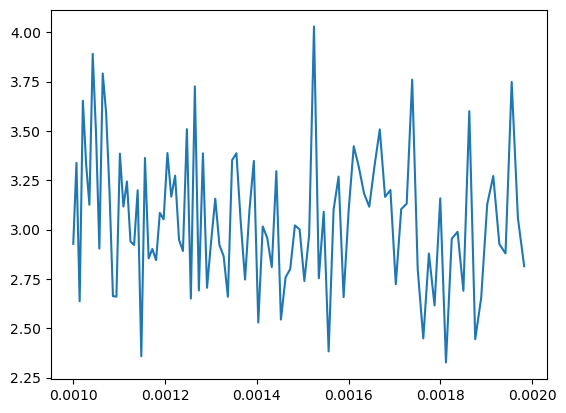

In [69]:
plt.plot(lri, lossi)

In [70]:
lri

[tensor(0.0010),
 tensor(0.0010),
 tensor(0.0010),
 tensor(0.0010),
 tensor(0.0010),
 tensor(0.0010),
 tensor(0.0010),
 tensor(0.0010),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0015),
 tensor(0.0015),
 tensor(0.0015),
 tensor(0.0015),
 tensor(0.0015

In [71]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(50):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + B1

      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + B2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

cartah.
aallijerh.
jmrzi.
thiy.
snaasan.
jmzhuen.
amerrhc.
aaeei.
nernnra.
ceziiv.
arle.
ndh.
amahdin.
edinn.
srlin.
ania.
bqyllztro.
djaryni.
jkqe.
ciusai.
edde.
oia.
etleahysrleaa.
aeyih.
jtvsya.
ambbzaoo.
rjioon.
iala.
rren.
ke.
sadlnagynne.
srloraa.
rynh.
aonkllibraa.
kaein.
oqe.
ryy.
bda.
adye.
uitegbnfmirdegjerniyla.
kemlesaa.
nnljadrk.
kallsusaimevmbtevl.
ky.
adyloo.
roao.
kton.
omarin.
ca.
losnszns.


## Conclusion

- The **MLP-based character-level model** significantly improves upon bigram models by capturing **longer dependencies** between characters.
- We observed that:
  - **Embeddings** provide compact representations of characters.
  - The **hidden layer** learns non-linear transformations, enabling the model to represent complex patterns.
  - Using **cross-entropy loss** ensures stable training compared to manual negative log-likelihood calculations.
  - **Mini-batches** and **learning rate tuning** are essential for efficient training on larger datasets.

- However, the model still faces challenges:
  - Explosive starting loss, which highlights the need for **smaller activation weights** at initialization.
  - Difficulty in **controlling gradients**, requiring careful tuning of optimization strategies.
  - Potential instability without techniques like **batch normalization**.
